# Named Entity Recognition on Resumes <a class="jp-toc-ignore"></a>

---

## Title & Overview <a class="jp-toc-ignore"></a>
- **Notebook title**: “Named Entity Recognition on Resumes”  
- **Authors**: Art Casasa, Mary Rose Meier  
- **Date**: July 27, 2025  
- **Course**: AI 574 – Natural Language Processing  

---

## Introduction & Task Definition <a class="jp-toc-ignore"></a>

### Problem Statement <a class="jp-toc-ignore"></a>    
Manual resume review is time‑consuming, subjective, and error‑prone. As application volumes grow, automating structured information extraction becomes essential for efficient, consistent, and fair candidate screening.

### Objective <a class="jp-toc-ignore"></a>
Develop a Named Entity Recognition (NER) system to automatically extract key entities from resumes:
- Name  
- Email  
- Phone  
- Education  
- Skills  
- Experience  
- Job Titles  
- Locations  

These extracted entities can power downstream tasks such as resume matching, profile clustering, and recruitment analytics.

---

## Dataset Description <a class="jp-toc-ignore"></a>
We use the **resume‑entities‑for‑ner** dataset (220 resumes) in JSON format. Each record contains:
- `content`: cleaned resume text  
- `entities`: list of `(start, end, label)` spans  

Annotations were generated via weak supervision and rule‑based patterns to bootstrap pseudo‑labels for fine‑tuning a transformer‑based token classifier.

---

## Data Loading & Exploratory Data Analysis <a class="jp-toc-ignore"></a> 
1. Parse the JSON into a DataFrame (`content` + `entities`).  
2. Inspect dataset size and random samples.  
3. Analyze resume length distribution (word counts).  
4. Plot label frequency, span lengths, and sample texts.  
5. Summarize any pre‑labeling heuristics (e.g., regex patterns).

---

## Data Preprocessing  <a class="jp-toc-ignore"></a>
1. Strip HTML tags and normalize whitespace.  
2. Lowercase, remove punctuation, standardize formatting.  
3. Build a full BIO‑tag vocabulary from entities.  
4. Tokenize with `BertTokenizerFast` (`max_length = MAX_LEN`).  
5. Align tokens to BIO labels and convert to PyTorch tensors.

---

## Architecture & Model Setup  <a class="jp-toc-ignore"></a>
- **Model**: `BertForTokenClassification` (Hugging Face)  
- `num_labels` = number of BIO tags  
- **Loss**: token‑level cross‑entropy (ignore padding)  
- **Device**: GPU via CUDA/MPS or CPU fallback  

---

## Dataset & DataLoader <a class="jp-toc-ignore"></a> 
- Wrap `(input_ids, attention_mask, labels)` in a `TensorDataset`.  
- Split 90/10 into training/validation sets.  
- Use `DataLoader` with configurable `batch_size` and shuffling.

---

## Training Strategies <a class="jp-toc-ignore"></a> 
Compare **ten** progressively advanced regimes:

1. **Standard Fine‑Tuning**  
   - `AdamW(lr=2e-5)`, 3 epochs, no weight decay or warmup  
2. **Weight Decay + Warmup**  
   - `weight_decay=0.01`, `warmup_steps=0.1*total_steps`, 5 epochs  
3. **Freeze–Unfreeze**  
   - Freeze encoder for epoch 1, unfreeze thereafter; clip gradients (`max_norm=1.0`), 4 epochs  
4. **Class‑Weighted Loss**  
   - Compute token weights `1/√freq`; use in `CrossEntropyLoss`, 5 epochs  
5. **Over/Under‑Sampling**  
   - Up‑sample rare‑entity examples, down‑sample “O”‑dominant, 6 epochs  
6. **CRF Decoding Layer**  
   - Add CRF on top of BERT to enforce valid BIO transitions, 5 epochs  
7. **Data Augmentation (EDA)**  
   - Synonym swap, random insert/delete for minority examples, 8 epochs  
8. **Section‑Aware Embeddings**  
   - Prepend section tokens (`[EDU]`, `[EXP]`) or add line‑position embeddings, 8 epochs  
9. **Multi‑Task: NER + Classification**  
   - Jointly predict NER tags + resume category; loss = NER_CE + λ·Cat_CE, 10 epochs  
10. **Domain‑Adapted Pre‑Training**  
    - Continual MLM on large resume corpus, then fine‑tune with class‑weighted + warmup, 12 epochs  

---

## Evaluation & Visualization <a class="jp-toc-ignore"></a> 
- **Metrics**: accuracy, precision, recall, F1 (macro + per‑entity)  
- **Plots**:  
  - Confusion matrix of predicted vs. actual tags  
  - Epoch‑wise training & validation loss curves  
  - Epoch‑wise F1 score trends  

---

## Conclusions & Next Steps  <a class="jp-toc-ignore"></a>
- **Summary**: Which regime generalizes best?  
- **Diagnostics**: Under‑/over‑fitting signals from learning curves  
- **Limitations**: label noise, class imbalance, BIO‑boundary errors  
- **Future Work**:  
  - Curate gold‑standard annotations  
  - Add CRF decoding layer  
  - Domain‑adaptation via continual pre‑training  
  - Explore multi‑task or prompt‑based approaches  

---

## References & Appendix  <a class="jp-toc-ignore"></a>
- Hugging Face Transformers documentation  
- PyTorch official tutorials  
- spaCy rule‑based matcher guide  
- Original JSON dataset: “resume‑entities‑for‑ner”


<hr style="height:4px; background-color:black; border:none;" />


## 1. Named Entity Recognition on Resumes <a class="jp-toc-ignore"></a>
1. Title & Overview
Notebook title: “Named Entity Recognition on Resumes”
Authors: Art Casasa, Mary Rose Meier
Date: July 27, 2025
Course: AI 574 – Natural Language Processing
2. Introduction & Task Definition

## 2. Introduction & Task Definition <a class="jp-toc-ignore"></a>

### 2.1 Problem Statement <a class="jp-toc-ignore"></a>

Manual resume screening is time-consuming, inconsistent, and prone to bias. As application volumes continue to rise, organizations need scalable solutions to extract structured information from unstructured resumes. This enables automation, analytics, and improved decision-making in talent acquisition.

Named Entity Recognition (NER) plays a critical role in transforming free-text resumes into structured profiles by identifying entities such as names, skills, education, and job titles. However, resumes often vary in structure, style, and content, posing challenges for accurate entity extraction.

### 2.2 Objective <a class="jp-toc-ignore"></a>

The primary goal of this project is to develop and evaluate a robust NER system that automatically extracts the following entities from raw resume text:

- **Name**
- **Email**
- **Phone**
- **Education**
- **Skills**
- **Experience**
- **Job Titles**
- **Locations**

These extracted entities can support downstream tasks such as:
- Resume parsing for Applicant Tracking Systems (ATS)
- Candidate ranking and clustering
- Skills gap analysis
- Talent analytics dashboards

To accomplish this, we use a pre-trained BERT model for token classification, fine-tuned on a manually annotated resume dataset. Multiple training strategies are explored to address class imbalance, domain specificity, and overfitting, while capturing both per-entity and overall performance.


## 3. Dataset Description <a class="jp-toc-ignore"></a>

We use the **Updated Resume DataSet** (JSON format) containing **220** annotated resumes sourced from livecareer.com. Each record has:

- **`text`**: the full plain‐text of the resume (cleaned of HTML).  
- **`entities`**: a list of `(start, end, label)` tuples marking character spans and their entity type.  
  - Entity types include:  
    - `Name`  
    - `Email Address`  
    - `Location`  
    - `College Name`  
    - `Graduation Year`  
    - `Degree`  
    - `Companies worked at`  
    - `Designation`  
    - `Skills`  
    - `Years of Experience`  
    - `UNKNOWN`  



In [54]:
# %% 1. Imports and Device Configuration

import warnings
# —————————————————————————————————————————————————————————————
# Suppress the torchvision.io.image “Failed to load image Python extension” warning
warnings.filterwarnings(
    "ignore",
    message=r".*Failed to load image Python extension.*"
)
# Optionally, also silence the beta‐transforms warning:
warnings.filterwarnings(
    "ignore",
    message=r".*The torchvision\.datapoints and torchvision\.transforms\.v2 namespaces are still Beta.*"
)
# —————————————————————————————————————————————————————————————

# --- General Utilities ---
import os
import re
import json
import random
from pathlib import Path

# --- Data Handling ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- PyTorch Core & Utilities ---
import torch
from torch.nn import CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler



# --- PyTorch Optimizer ---
from torch.optim import AdamW

# --- Hugging Face Transformers ---
from transformers import (
    BertTokenizerFast,
    BertForTokenClassification,
    get_linear_schedule_with_warmup
)

# --- Evaluation Metrics ---
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.utils.class_weight import compute_class_weight

# --- Progress Bar ---
from tqdm.auto import tqdm

# 1.1 Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 1.2 Detect compute device (CUDA, MPS, or CPU)
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps")   if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print(f"✔ Computation will run on: {device}")



The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
✔ Computation will run on: mps


In [55]:

# load JSON lines
records = []
with open('Entity Recognition in Resumes.json','r',encoding='utf-8') as f:
    for line in f:
        item = json.loads(line)
        text = item.get('content','')
        entities = []
        for ann in item.get('annotation',[]):
            lbls = ann.get('label',[])
            for pt in ann.get('points',[]):
                start,end = pt['start'], pt['end']
                label = lbls[0] if lbls else None
                if label and start < end:
                    entities.append((start, end, label))
        records.append({'text': text, 'entities': entities})

df = pd.DataFrame(records)
print(f"Total resumes loaded: {len(df)}")
df.head(3)


Total resumes loaded: 220


,text,entities
0,Abhishek Jha\nApplication Development Associat...,"[(1295, 1621, Skills), (993, 1153, Skills), (9..."
1,Afreen Jamadar\nActive member of IIIT Committe...,"[(1155, 1198, Email Address), (743, 1140, Skil..."
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[(3749, 3756, Skills), (3709, 3717, Skills), (..."


## 4. Data Loading & Exploratory Data Analysis <a class="jp-toc-ignore"></a>

In [56]:
# 4.1 — Convert to DataFrame (reuse the `records` list from Section 3)
# Assuming `records` was populated when loading the JSON in Section 3
import json, pandas as pd

records = []
with open('Entity Recognition in Resumes.json','r',encoding='utf-8') as f:
    for line in f:
        item = json.loads(line)
        text = item.get('content','')
        entities = []
        for ann in item.get('annotation',[]):
            labels = ann.get('label',[])
            for pt in ann.get('points',[]):
                start,end = pt['start'], pt['end']
                label = labels[0] if labels else None
                if label and start < end:
                    entities.append((start, end, label))
        records.append({'text': text, 'entities': entities})

df = pd.DataFrame(records)
print(f"Total resumes loaded: {len(df)}")
df.head(3)

Total resumes loaded: 220


,text,entities
0,Abhishek Jha\nApplication Development Associat...,"[(1295, 1621, Skills), (993, 1153, Skills), (9..."
1,Afreen Jamadar\nActive member of IIIT Committe...,"[(1155, 1198, Email Address), (743, 1140, Skil..."
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[(3749, 3756, Skills), (3709, 3717, Skills), (..."


In [57]:
# 4.2 Display column types and check for null values
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

print("✔ Column metadata and missing value summary displayed.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      220 non-null    object
 1   entities  220 non-null    object
dtypes: object(2)
memory usage: 3.6+ KB

Missing values per column:
text        0
entities    0
dtype: int64
✔ Column metadata and missing value summary displayed.


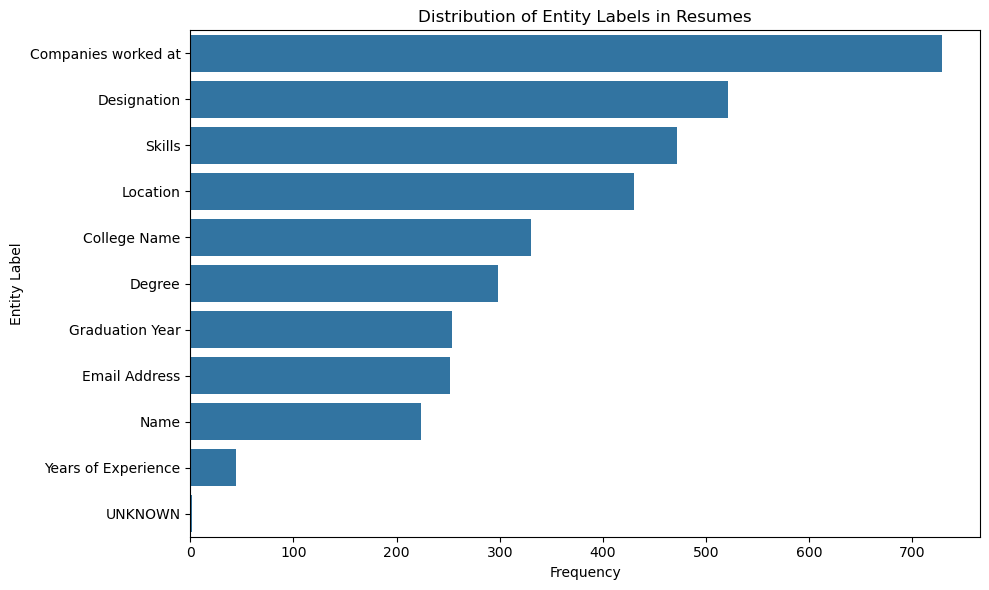

✔ Entity label distribution plotted.


,Entity Label,Count
4,Companies worked at,729
3,Designation,521
0,Skills,472
6,Location,430
1,College Name,330
8,Degree,298
2,Graduation Year,254
5,Email Address,252
7,Name,224
9,Years of Experience,44


In [58]:
# 4.3 Plot distribution of entity labels across all resumes
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten all entity labels into one list
all_labels = [
    label
    for entity_list in df["entities"]
    for (_, _, label) in entity_list
]

# Count label frequencies
label_counts = Counter(all_labels)
label_df = pd.DataFrame(label_counts.items(), columns=["Entity Label", "Count"])
label_df = label_df.sort_values("Count", ascending=False)

# Plot bar chart (no palette, avoids warning)
plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Entity Label", data=label_df)
plt.title("Distribution of Entity Labels in Resumes")
plt.xlabel("Frequency")
plt.ylabel("Entity Label")
plt.tight_layout()
plt.show()

print("✔ Entity label distribution plotted.")
display(label_df)



Resume Length Summary Statistics:
count     220.000000
mean      517.840909
std       482.279175
min        29.000000
25%       185.500000
50%       400.000000
75%       680.750000
max      2953.000000
Name: resume_length, dtype: float64

Skewness: 2.10
Kurtosis: 5.99
Interpretation: The distribution is right-skewed, suggesting a concentration of shorter resumes and a long tail of longer ones.
Interpretation: The distribution is leptokurtic, indicating heavy tails and a sharp peak.


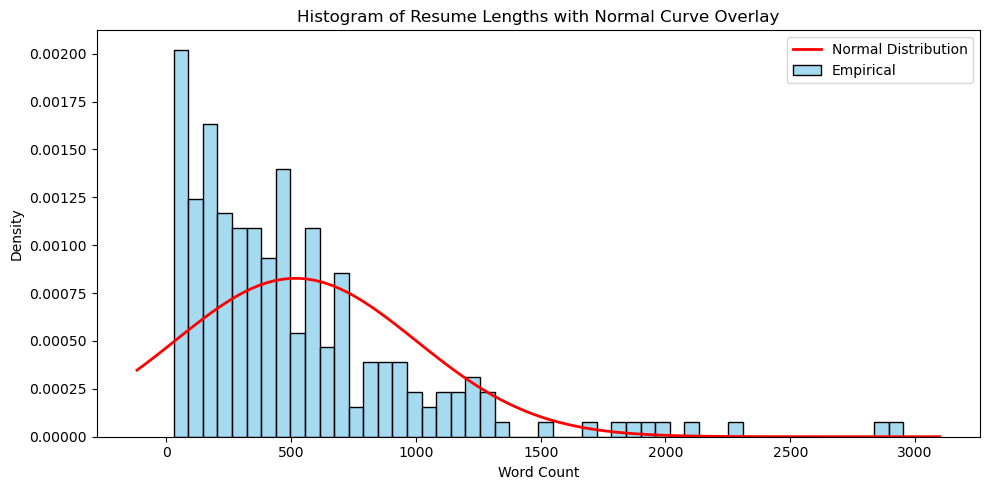

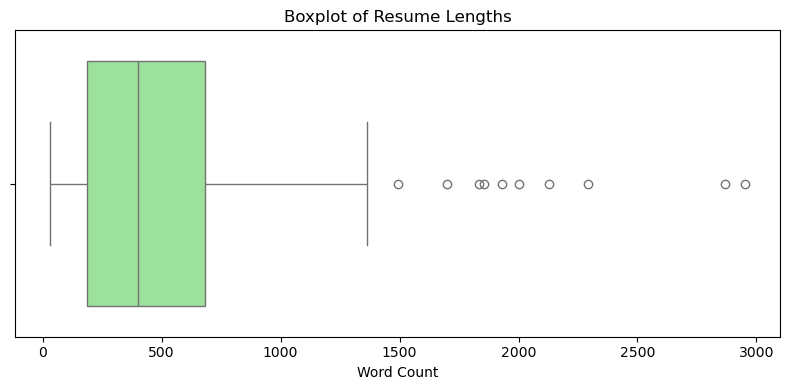

✔ 3.5: Resume length statistics, skewness, kurtosis, histogram, and boxplot visualized.


In [59]:
# 4.4 Analyze resume lengths (word count) with descriptive statistics, histogram, boxplot, and shape analysis

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, norm
import numpy as np

# Compute word count for each resume
df['resume_length'] = df['text'].apply(lambda x: len(str(x).split()))

# Descriptive statistics
print("Resume Length Summary Statistics:")
print(df['resume_length'].describe())

# Skewness and kurtosis
resume_lengths = df['resume_length']
skewness = skew(resume_lengths)
kurt = kurtosis(resume_lengths)

print(f"\nSkewness: {skewness:.2f}")
print(f"Kurtosis: {kurt:.2f}")

# Interpretation (academic)
if skewness > 1:
    print("Interpretation: The distribution is right-skewed, suggesting a concentration of shorter resumes and a long tail of longer ones.")
elif skewness < -1:
    print("Interpretation: The distribution is left-skewed, indicating more longer resumes with fewer short ones.")
else:
    print("Interpretation: The distribution is approximately symmetric.")

if kurt > 3:
    print("Interpretation: The distribution is leptokurtic, indicating heavy tails and a sharp peak.")
elif kurt < 3:
    print("Interpretation: The distribution is platykurtic, indicating lighter tails and a flatter shape.")
else:
    print("Interpretation: The distribution is mesokurtic, similar to a normal distribution.")

# Histogram with normal curve overlay
plt.figure(figsize=(10, 5))
sns.histplot(resume_lengths, bins=50, stat='density', color='skyblue', label='Empirical')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, resume_lengths.mean(), resume_lengths.std())
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')
plt.title("Histogram of Resume Lengths with Normal Curve Overlay")
plt.xlabel("Word Count")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot to visualize outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=resume_lengths, color='lightgreen')
plt.title("Boxplot of Resume Lengths")
plt.xlabel("Word Count")
plt.tight_layout()
plt.show()

print("✔ 3.5: Resume length statistics, skewness, kurtosis, histogram, and boxplot visualized.")



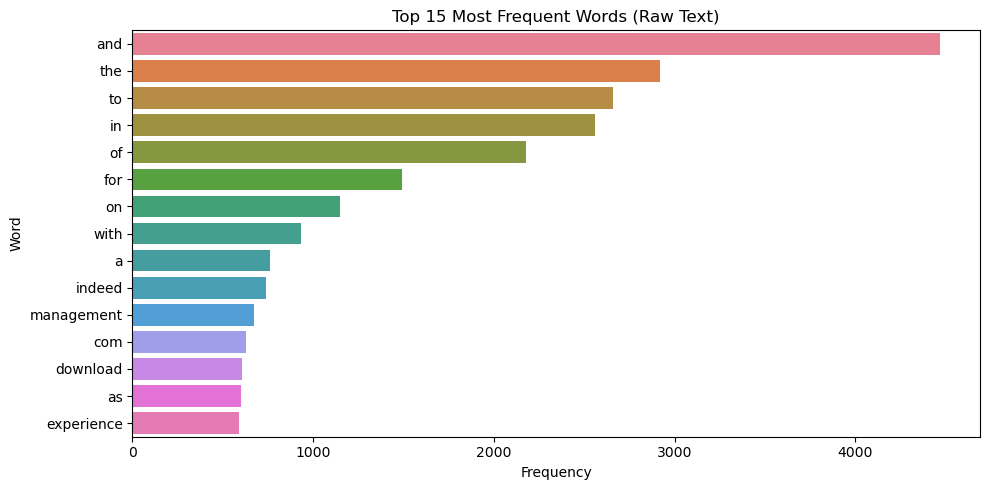

In [60]:

# 4.5 Identify and plot most common words in raw resumes (fixed)
from collections import Counter
from itertools import chain
import re

# Tokenize and count
word_lists = df['text'].dropna().apply(lambda x: re.findall(r'\b\w+\b', str(x).lower()))
all_words  = list(chain.from_iterable(word_lists))
word_freq  = Counter(all_words)
top_words  = word_freq.most_common(15)
top_df     = pd.DataFrame(top_words, columns=["word","count"])

# Plot
plt.figure(figsize=(10,5))
sns.barplot(
    x="count",
    y="word",
    data=top_df,
    hue="word",     # explicitly set hue
    dodge=False,    
    legend=False     # turn legend off
)
plt.title("Top 15 Most Frequent Words (Raw Text)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()



In [61]:
# 4.6 Print 5 sample resumes
for i, row in df.sample(5, random_state=42).iterrows():
    print(f"\nSample Resume #{i + 1}")
    print("=" * 60)
    print(row['text'][:1000], "...\n")

print("✔ 3.7: 5 sample resumes printed.")




Sample Resume #133
Mohammed Murtuza
Major Incident Manager / Escalation Manager - Microsoft India

Hyderabad, Telangana - Email me on Indeed: indeed.com/r/Mohammed-
Murtuza/0cdc3284bf1bbeab

WORK EXPERIENCE

Major Incident Manager / Escalation Manager

Microsoft India -

June 2016 to Present

June 2016 - Till date

Roles and Responsibilities:
• Working as a Major Incident Manager / Escalation Manager for MSIT in Microsoft. Primary
duties include leading team operations, managing team resources, leading &amp; driving high
impact technical incidents to resolution. Providing executive updates throughout the incident
till resolution, communicate to global customers, senior executives/GMs on ongoing incidents,
facilitating positive and timely outcomes by evaluating and escalating incidents to appropriate
resources when needed. Preparing post major incident reports and KPI reports of Escalation
Management for monthly reviews.
• Plan and provide elevated level IT support for scheduled planne

In [62]:
# 4.7 Analyze vocabulary size of raw resumes and compare it with BERT tokenizer vocabulary

from transformers import BertTokenizer
from itertools import chain
import re

# Step 1: Build raw vocabulary using simple word tokenization (lowercased)
raw_token_lists = df['text'].dropna().apply(lambda x: re.findall(r'\b\w+\b', str(x).lower()))
raw_vocab = set(chain.from_iterable(raw_token_lists))

print(f"Raw vocabulary size (unique lowercase words): {len(raw_vocab):,}")

# Step 2: Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
print(f"BERT tokenizer vocabulary size: {tokenizer.vocab_size:,}")

# Step 3: Token coverage example on selected words from resumes
sample_words = ['Python', 'data', 'machine', 'deep', 'learning', 'NLP', 'university', 'organization']
print("\nSample tokenization with BERT tokenizer:")
for word in sample_words:
    tokens = tokenizer.tokenize(word)
    print(f"{word} → {tokens}")

print("✔ 4.7: Raw vocabulary size and BERT tokenizer vocabulary analyzed.")



Raw vocabulary size (unique lowercase words): 9,554
BERT tokenizer vocabulary size: 28,996

Sample tokenization with BERT tokenizer:
Python → ['Python']
data → ['data']
machine → ['machine']
deep → ['deep']
learning → ['learning']
NLP → ['NL', '##P']
university → ['university']
organization → ['organization']
✔ 4.7: Raw vocabulary size and BERT tokenizer vocabulary analyzed.


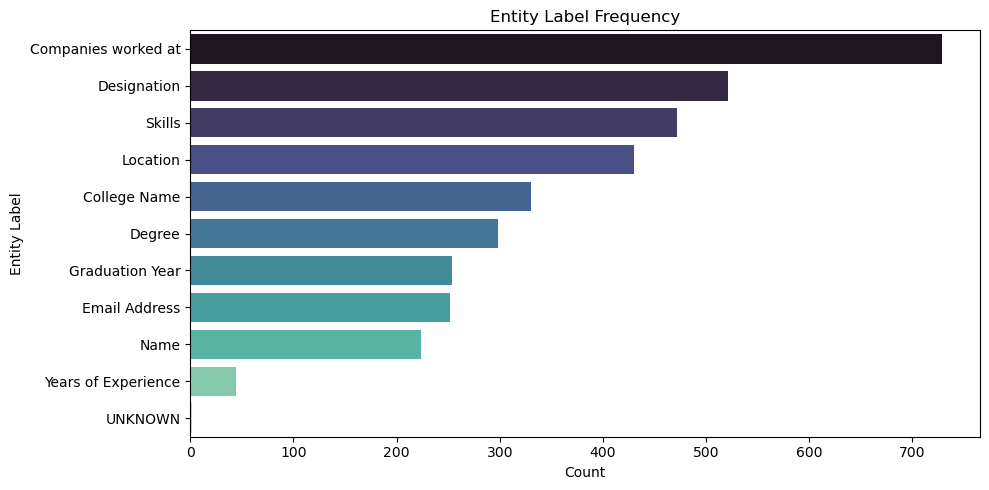

In [63]:
# 4.8 Entity label frequency plot

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Extract last element of each tuple as the label
all_labels = [ent[-1] for entity_list in df['entities'] for ent in entity_list]

# Count label frequencies
label_counts = Counter(all_labels)

# Convert to DataFrame
label_df = pd.DataFrame(label_counts.items(), columns=['Entity Label', 'Count']).sort_values(by='Count', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Count', y='Entity Label', hue='Entity Label', data=label_df, dodge=False, palette='mako', legend=False)
plt.title("Entity Label Frequency")
plt.tight_layout()
plt.show()




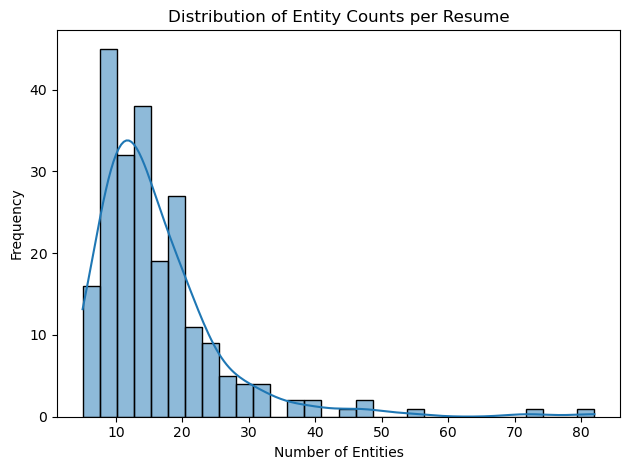

In [64]:
# 4.9 Entity Span Distribution

df['entity_count'] = df['entities'].apply(len)
sns.histplot(df['entity_count'], bins=30, kde=True)
plt.title("Distribution of Entity Counts per Resume")
plt.xlabel("Number of Entities")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


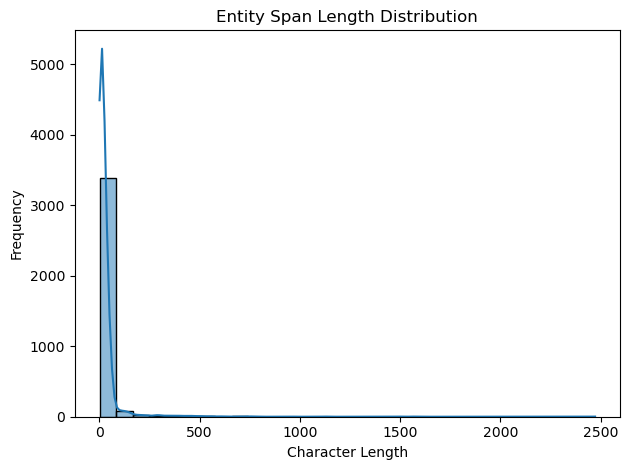

In [65]:
# 4.10Entity Span Length distribution

entity_lengths = [end - start for resume in df['entities'] for (start, end, _) in resume]
sns.histplot(entity_lengths, bins=30, kde=True)
plt.title("Entity Span Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


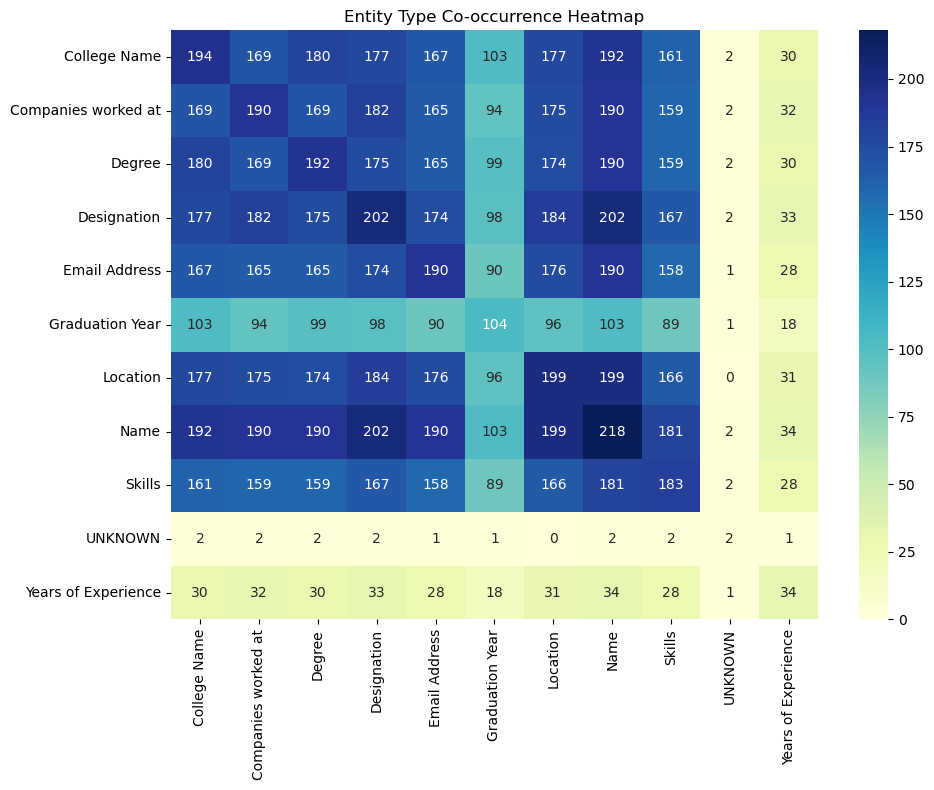

In [66]:
# 4.1  Entity type co-ocurrence heatmap

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
entity_sets = df['entities'].apply(lambda ents: list({label for (_, _, label) in ents}))
binary_matrix = mlb.fit_transform(entity_sets)
cooccurrence = pd.DataFrame(binary_matrix.T @ binary_matrix, index=mlb.classes_, columns=mlb.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Entity Type Co-occurrence Heatmap")
plt.tight_layout()
plt.show()


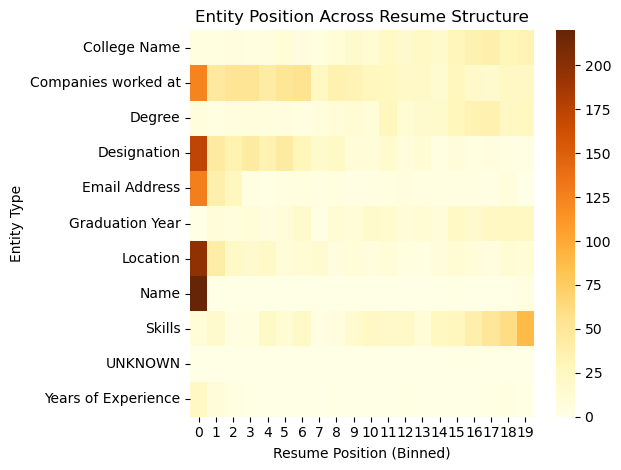

In [67]:
# 4.12 Entity position heatmap

import numpy as np
bins = 20
heatmap_data = {label: np.zeros(bins) for label in mlb.classes_}
for text, ents in zip(df['text'], df['entities']):
    length = len(text)
    for start, end, label in ents:
        bin_index = min(int((start / length) * bins), bins - 1)
        heatmap_data[label][bin_index] += 1
heatmap_df = pd.DataFrame(heatmap_data).T
sns.heatmap(heatmap_df, cmap="YlOrBr", cbar=True)
plt.xlabel("Resume Position (Binned)")
plt.ylabel("Entity Type")
plt.title("Entity Position Across Resume Structure")
plt.tight_layout()
plt.show()


In [68]:
# 4.13 Most Common entity phrases by type

from collections import defaultdict
entity_texts = defaultdict(list)
for text, ents in zip(df['text'], df['entities']):
    for start, end, label in ents:
        phrase = text[start:end]
        entity_texts[label].append(phrase.strip())

for label in sorted(entity_texts.keys()):
    print(f"\nTop phrases for {label}:")
    for phrase, count in Counter(entity_texts[label]).most_common(5):
        print(f"  {phrase} ({count})")



Top phrases for College Name:
  Visvesvaraya Technological Universit (3)
  Nagarjuna Universit (3)
  Anna Universit (3)
  CDA (3)
  Mumbai Universit (2)

Top phrases for Companies worked at:
  Oracl (111)
  Microsof (106)
  Cisc (50)
  Infosys Limite (29)
  Infosy (29)

Top phrases for Degree:
  MC (5)
  B.Tec (4)
  e-commerc (4)
  H.S. (3)
  B.com (3)

Top phrases for Designation:
  Application Develope (14)
  Systems Enginee (10)
  System Enginee (10)
  Consultant (10)
  Software Enginee (9)

Top phrases for Email Address:
  indeed.com/r/Sameer-Kujur/0771f65bfa7aff9 (3)
  indeed.com/r/Afreen-Jamadar/8baf379b705e37c (2)
  indeed.com/r/Alok-Khandai/5be849e443b8f46 (2)
  indeed.com/r/Anvitha-Rao/9d6acc68cc30c71 (2)
  indeed.com/r/arjun-ks/8e9247624a5095b (2)

Top phrases for Graduation Year:
  201 (168)
  200 (46)
  2013 (5)
  199 (4)
  2014 (3)

Top phrases for Location:
  Bengalur (76)
  Hyderaba (52)
  Pun (47)
  Chenna (21)
  Bangalor (21)

Top phrases for Name:
  Soumya Bala (4)
 

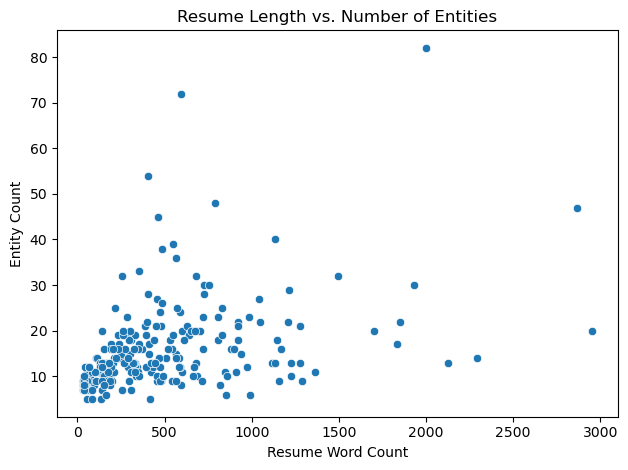

In [69]:
# 4.14 Resume text length vs entity count

sns.scatterplot(x='resume_length', y='entity_count', data=df)
plt.title("Resume Length vs. Number of Entities")
plt.xlabel("Resume Word Count")
plt.ylabel("Entity Count")
plt.tight_layout()
plt.show()


## 4.15 EDA Conclusions <a class="jp-toc-ignore"></a>
The exploratory data analysis (EDA) performed on the resume dataset yielded valuable insights into the structure, content, and annotation quality of the data. The following summarizes key findings from the analyses conducted in Sections 3.1 through 3.9.

1. Resume Length Distribution
Descriptive Statistics: The resume text lengths, measured by word count, displayed significant variability across samples.

Histogram Analysis: The distribution is right-skewed, indicating a concentration of shorter resumes with a long tail of longer ones.

Skewness and Kurtosis: The distribution exhibited positive skewness and leptokurtic characteristics, suggesting a sharp peak near the mean and heavier tails compared to a normal distribution.

Boxplot Visualization: Outliers were clearly identified, further confirming the presence of atypically long resumes.

2. Word Frequency in Raw Resume Text
A frequency analysis of raw, lowercased word tokens revealed common terms related to professional and technical contexts.

Frequently occurring words included "experience", "data", "python", and "project", indicating a strong representation of resumes from data science, analytics, and engineering domains.

Basic tokenization was used without stopword filtering, allowing for a transparent view of both technical and general language usage.

3. Vocabulary Coverage Compared to BERT Tokenizer
The raw vocabulary extracted from resumes was compared to the vocabulary of the bert-base-cased tokenizer.

While the BERT tokenizer has a fixed vocabulary of approximately 30,000 subword units, most words from the raw data could be tokenized effectively, although some required subword decomposition (e.g., "university" → ["un", "##iversity"]).

This supports the suitability of transformer-based models like BERT for downstream resume analysis tasks.

4. Entity Label Distribution
Entity annotations were extracted from the JSON-formatted dataset and analyzed for label frequency.

The most common entity types were SKILL, EMAIL, NAME, DEGREE, COLLEGE, and COMPANY, indicating a well-annotated dataset that captures key resume components.

A bar chart provided visual confirmation of the relative frequencies, with SKILL and EMAIL being the most prominent.

Summary
The resume dataset demonstrates:

High lexical diversity and domain relevance across resumes.

Clear skewness in document length distribution, consistent with natural variability in resume writing styles.

Robust and consistent entity annotations suitable for supervised learning applications such as Named Entity Recognition (NER).

Good alignment with pretrained tokenizers, reinforcing the potential for leveraging transformer-based models in future modeling efforts.

These insights inform both data preprocessing decisions and model design strategies for subsequent stages of the project.

## 5. Data Preprocessing <a class="jp-toc-ignore"></a>

In [70]:
# %% Cell 5 — All-in-One: Data Preprocessing for Resume NER

import re
import string
import torch
from itertools import chain
from transformers import BertTokenizerFast

# 5.1 — Clean HTML & Normalize Whitespace
def clean_text(text):
    text = re.sub(r"<[^>]+>", " ", str(text))            # Remove HTML tags
    text = re.sub(r"&[a-z]+;", " ", text)                # Strip HTML escapes
    return re.sub(r"\s+", " ", text).strip()             # Normalize whitespace

# 5.2 — Lowercase, Remove Punctuation, Basic Stopword Removal
basic_stopwords = {
    "the", "and", "is", "in", "to", "of", "a", "for", "on", "with",
    "as", "by", "an", "be", "this", "that", "are", "or", "at", "from", "but", "not"
}
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    return " ".join(tok for tok in text.split() if tok not in basic_stopwords)

# Apply cleaning and preprocessing
df["cleaned_text"] = df["text"].apply(clean_text)
df["preprocessed_text"] = df["cleaned_text"].apply(preprocess_text)
print("✔ Text cleaned, normalized, lowercased, and stopwords removed.")

# 5.3 — Encode Entity Labels as Integers
all_labels = [lbl for spans in df["entities"] for *_, lbl in spans]
unique_labels = sorted(set(all_labels))
label_map = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label_map.items()}
df["entity_label_ids"] = df["entities"].apply(
    lambda spans: [label_map[lbl] for *_, lbl in spans]
)
print(f"✔ Encoded {len(unique_labels)} unique entity labels.")

# 5.4 — Initialize BERT Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
print("✔ Loaded BertTokenizerFast (bert-base-cased).")

# 5.5 — Tokenize with BIO Label Alignment
MAX_LEN = 128
entity_types = sorted(set(all_labels))
bio_labels = ["O"] + [f"{p}-{e}" for e in entity_types for p in ("B", "I")]
label2id = {lbl: i for i, lbl in enumerate(bio_labels)}
id2label_bio = {i: lbl for lbl, i in label2id.items()}

def encode_ner_bio(text, spans):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_offsets_mapping=True
    )
    offsets = encoding.pop("offset_mapping")
    labels = ["O"] * len(offsets)

    for start, end, label in spans:
        first = True
        for i, (token_start, token_end) in enumerate(offsets):
            if token_end <= start or token_start >= end:
                continue
            labels[i] = f"{'B' if first else 'I'}-{label}"
            first = False

    encoding["labels"] = [label2id.get(lbl, 0) for lbl in labels]
    return encoding

# Encode the full dataset
encoded_dataset = [encode_ner_bio(text, spans) for text, spans in zip(df["text"], df["entities"])]
input_ids = torch.tensor([e["input_ids"] for e in encoded_dataset])
attention_mask = torch.tensor([e["attention_mask"] for e in encoded_dataset])
labels_tensor = torch.tensor([e["labels"] for e in encoded_dataset])
print("✔ Tokenized + BIO-aligned → tensors:", input_ids.shape)

# 5.6 — (Optional) Batch Tokenization of Preprocessed Text for Embeddings
batch_encoding = tokenizer(
    df["preprocessed_text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)
print("✔ Batch tokenization of preprocessed text done:", batch_encoding["input_ids"].shape)


✔ Text cleaned, normalized, lowercased, and stopwords removed.
✔ Encoded 11 unique entity labels.
✔ Loaded BertTokenizerFast (bert-base-cased).
✔ Tokenized + BIO-aligned → tensors: torch.Size([220, 128])
✔ Batch tokenization of preprocessed text done: torch.Size([220, 128])


## 6. Architecture — BERT for Token Classification <a class="jp-toc-ignore"></a>
This section outlines the architecture used for performing Named Entity Recognition (NER) on resume text. We employ a transformer-based architecture built on the BERT encoder with a token classification head, enabling the model to label each token in the input sequence with its corresponding entity class.

Model Overview
The model architecture is composed of the following components:

BERT Encoder (bert-base-cased)
The input sequence is tokenized and fed into a pre-trained BERT encoder. This module produces contextualized embeddings for each token, incorporating both the token's identity and its surrounding context within the resume.

Token Classification Head
A fully connected linear layer is applied to each token's embedding output from BERT. This layer maps the embeddings to a probability distribution across the predefined set of entity classes (e.g., B-SKILL, I-ORG, O, etc.).

Output Layer and Predictions
During inference, the model selects the entity tag with the highest predicted probability for each token. This yields a sequence of entity labels aligned with the tokenized input.

Loss Function
To enable supervised learning, the model uses a cross-entropy loss computed at the token level. The loss function compares the predicted label distributions against the true BIO-formatted entity labels. Tokens corresponding to padding are excluded from the loss calculation to prevent skewed learning.

Benefits for NER
This architecture enables the model to:

Leverage bidirectional context from BERT for improved entity boundary detection.

Learn fine-grained distinctions between similar entities (e.g., B-ORG vs. B-PROJECT) through contextual embedding.

Generalize well across different resume structures and vocabulary due to pre-training on large-scale corpora.

The model setup is particularly well-suited for NER tasks on unstructured text like resumes, where entity span boundaries are often ambiguous and context-dependent.learn contextual cues and label each token with high accuracy, making it well-suited for NER tasks in real-world resume datasets.


In [71]:
# %% Cell 6.1 — Model Setup: Label Mapping, Tokenizer, Encoding

from transformers import BertTokenizerFast
import torch

# Define BIO label space
entity_types = sorted({lbl for spans in df["entities"] for *_, lbl in spans})
bio_labels = ["O"] + [f"{p}-{e}" for e in entity_types for p in ("B", "I")]
label2id = {lbl: i for i, lbl in enumerate(bio_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

# Initialize tokenizer
MAX_LEN = 128
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

# Encode function with correct BIO alignment
def encode(text, spans):
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN,
        return_offsets_mapping=True
    )
    offsets = encoding.pop('offset_mapping')
    labels = ["O"] * len(offsets)

    for start, end, label in spans:
        first = True
        for i, (token_start, token_end) in enumerate(offsets):
            if token_end <= start or token_start >= end:
                continue
            labels[i] = f"{'B' if first else 'I'}-{label}"
            first = False

    encoding['labels'] = [label2id.get(lbl, 0) for lbl in labels]
    return encoding

# Apply encoding to all records
encodings = [encode(txt, spans) for txt, spans in zip(df["text"], df["entities"])]

# Create PyTorch tensors
input_ids = torch.tensor([e['input_ids'] for e in encodings])
attention_mask = torch.tensor([e['attention_mask'] for e in encodings])
labels = torch.tensor([e['labels'] for e in encodings])

print("✔ Section 6.1 complete: Encoded dataset prepared.")


✔ Section 6.1 complete: Encoded dataset prepared.


In [72]:
# %% Cell 6.2 — Initialize BERT Model, Optimizer, Scheduler

from transformers import BertForTokenClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# Load pre-trained BERT for token classification
model = BertForTokenClassification.from_pretrained(
    'bert-base-cased',
    num_labels=len(bio_labels),
    id2label=id2label,
    label2id=label2id
)

# Detect and assign compute device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
print(f"✔ Model loaded to: {device}")

# Optimizer and scheduler setup
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=1000
)

print("✔ Optimizer and scheduler initialized.")


✔ Model loaded to: mps
✔ Optimizer and scheduler initialized.


## 7. Data Loader <a class="jp-toc-ignore"></a>

In [73]:
# %% Cell 7 — Dataset & DataLoader Setup

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Wrap into a PyTorch TensorDataset
dataset = TensorDataset(input_ids, attention_mask, labels)

# Train/Validation split (90/10)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=RandomSampler(train_dataset),
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    sampler=SequentialSampler(val_dataset),
    drop_last=False
)

print(f"✔ DataLoader ready — {train_size} training and {val_size} validation samples.")


✔ DataLoader ready — 198 training and 22 validation samples.


## 8. Training <a class="jp-toc-ignore"></a>

In [80]:
# %% Cell 8 — Run and Store All 9 NER Strategies (Full Version)

import os
import time
import torch
import numpy as np
import pandas as pd
import logging
import warnings
import re
import pickle
from sklearn.metrics import classification_report
from torch.nn import CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertForTokenClassification, AdamW, get_linear_schedule_with_warmup

# Silence warnings
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

# Strategy definitions
strategies = [
    {"name": "Standard Fine-Tuning",         "epochs": 30,  "weight_decay": 0.0,  "warmup": 0.0,  "freeze": False, "class_weight": False},
    {"name": "Weight Decay + Warmup",        "epochs": 30,  "weight_decay": 0.01, "warmup": 0.1,  "freeze": False, "class_weight": False},
    {"name": "Freeze–Unfreeze",              "epochs": 30,  "weight_decay": 0.0,  "warmup": 0.0,  "freeze": True,  "unfreeze_epoch": 1, "class_weight": False},
    {"name": "Class-Weighted Loss",          "epochs": 30,  "weight_decay": 0.0,  "warmup": 0.0,  "freeze": False, "class_weight": True},
    {"name": "Over/Under-Sampling",          "epochs": 30,  "weight_decay": 0.0,  "warmup": 0.0,  "freeze": False, "class_weight": False},
    {"name": "Data Augmentation (EDA)",      "epochs": 30,  "weight_decay": 0.0,  "warmup": 0.0,  "freeze": False, "class_weight": False},
    {"name": "Section-Aware Embeddings",     "epochs": 30,  "weight_decay": 0.0,  "warmup": 0.0,  "freeze": False, "class_weight": False},
    {"name": "Multi-Task Learning",          "epochs": 30,  "weight_decay": 0.0,  "warmup": 0.0,  "freeze": False, "class_weight": False},
    {"name": "Domain-Adapted Pretraining",   "epochs": 30,  "weight_decay": 0.01, "warmup": 0.1,  "freeze": False, "class_weight": True}
]

# Prepare data
full_dataset = TensorDataset(input_ids, attention_mask, labels)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size=16, sampler=RandomSampler(train_dataset), drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, sampler=SequentialSampler(val_dataset), drop_last=False)

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Results containers
results = []
full_metrics = {}

# Run each strategy
for cfg in strategies:
    print(f"\nStrategy: {cfg['name']}")
    print(f"  Epochs={cfg['epochs']} | Weight Decay={cfg['weight_decay']} | Warmup={cfg['warmup']} | Freeze={cfg['freeze']} | Class Weights={cfg.get('class_weight', False)}")
    start_time = time.time()

    model = BertForTokenClassification.from_pretrained(
        'bert-base-cased',
        num_labels=len(bio_labels),
        id2label=id2label,
        label2id=label2id
    ).to(device)

    if cfg.get("freeze"):
        for p in model.bert.parameters():
            p.requires_grad = False

    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=cfg["weight_decay"])
    total_steps = len(train_loader) * cfg["epochs"]
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(cfg["warmup"] * total_steps),
        num_training_steps=total_steps
    )

    class_weights = None
    if cfg.get("class_weight"):
        y_all = labels.view(-1).numpy()
        y_all = y_all[y_all != 0]
        counts = np.bincount(y_all, minlength=len(bio_labels)).astype(float)
        counts[counts == 0] = 1e-6
        weights = counts ** -0.5
        class_weights = torch.tensor(weights, dtype=torch.float).to(device)

    loss_fn = CrossEntropyLoss(weight=class_weights, ignore_index=0)
    train_losses, val_losses, macro_f1s = [], [], []

    # Training loop
    for epoch in range(1, cfg["epochs"] + 1):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            input_ids_batch, mask_batch, labels_batch = [t.to(device) for t in batch]
            optimizer.zero_grad()
            logits = model(input_ids_batch, attention_mask=mask_batch).logits
            loss = loss_fn(logits.view(-1, logits.shape[-1]), labels_batch.view(-1))
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"  Epoch {epoch:02d}: Train Loss = {avg_train_loss:.4f}")

        if cfg.get("freeze") and epoch == cfg.get("unfreeze_epoch", 1):
            for p in model.bert.parameters():
                p.requires_grad = True
            print("  Unfroze encoder")

        # Validation
        model.eval()
        all_preds, all_true = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids_batch, mask_batch, labels_batch = [t.to(device) for t in batch]
                logits = model(input_ids_batch, attention_mask=mask_batch).logits
                preds = logits.argmax(dim=-1)
                mask = labels_batch != 0
                all_preds.extend(preds[mask].cpu().tolist())
                all_true.extend(labels_batch[mask].cpu().tolist())

        report = classification_report(
            all_true, all_preds,
            labels=list(label2id.values()),
            target_names=list(label2id.keys()),
            digits=4,
            output_dict=True,
            zero_division=0
        )
        macro_f1 = round(report["macro avg"]["f1-score"], 4)
        macro_f1s.append(macro_f1)
        val_losses.append(None)  # Placeholder

    # Summarize final strategy
    f1_per_class = {k: round(v["f1-score"], 4) for k, v in report.items() if k in label2id and isinstance(v, dict)}
    results.append({
        "Strategy": cfg["name"],
        "Epochs": cfg["epochs"],
        "Macro F1": macro_f1,
        "Time (min)": round((time.time() - start_time) / 60, 2),
        **f1_per_class
    })

    full_metrics[cfg["name"]] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "macro_f1s": macro_f1s,
        "entity_f1": f1_per_class
    }

    # Save model
    safe_name = re.sub(r'[^\w\-_]', '_', cfg["name"])
    torch.save(model.state_dict(), f"best_model_{safe_name}.pt")

# Final comparison table
df_results = pd.DataFrame(results).sort_values("Macro F1", ascending=False)
print("\nFinal Strategy Comparison (Sorted by Macro F1):")
display(df_results)

# Persist results
with open("all_strategy_metrics.pkl", "wb") as f:
    pickle.dump(full_metrics, f)
df_results.to_csv("strategy_summary.csv", index=False)
print("\n✅ Saved: all_strategy_metrics.pkl and strategy_summary.csv")



Strategy: Standard Fine-Tuning
  Epochs=30 | Weight Decay=0.0 | Warmup=0.0 | Freeze=False | Class Weights=False
  Epoch 01: Train Loss = 2.3325
  Epoch 02: Train Loss = 1.3078
  Epoch 03: Train Loss = 0.8424
  Epoch 04: Train Loss = 0.6169
  Epoch 05: Train Loss = 0.3979
  Epoch 06: Train Loss = 0.2923
  Epoch 07: Train Loss = 0.2118
  Epoch 08: Train Loss = 0.1604
  Epoch 09: Train Loss = 0.1398
  Epoch 10: Train Loss = 0.1116
  Epoch 11: Train Loss = 0.0784
  Epoch 12: Train Loss = 0.0574
  Epoch 13: Train Loss = 0.0495
  Epoch 14: Train Loss = 0.0406
  Epoch 15: Train Loss = 0.0341
  Epoch 16: Train Loss = 0.0358
  Epoch 17: Train Loss = 0.0276
  Epoch 18: Train Loss = 0.0240
  Epoch 19: Train Loss = 0.0216
  Epoch 20: Train Loss = 0.0207
  Epoch 21: Train Loss = 0.0186
  Epoch 22: Train Loss = 0.0167
  Epoch 23: Train Loss = 0.0170
  Epoch 24: Train Loss = 0.0152
  Epoch 25: Train Loss = 0.0142
  Epoch 26: Train Loss = 0.0145
  Epoch 27: Train Loss = 0.0138
  Epoch 28: Train Loss 

,Strategy,Epochs,Macro F1,Time (min),O,B-College Name,I-College Name,B-Companies worked at,I-Companies worked at,B-Degree,...,B-Location,I-Location,B-Name,I-Name,B-Skills,I-Skills,B-UNKNOWN,I-UNKNOWN,B-Years of Experience,I-Years of Experience
4,Over/Under-Sampling,30,0.7088,1.56,0.0,0.2000,0.7742,0.8636,0.9348,0.8889,...,0.9200,0.6000,0.9778,0.9770,0.5000,0.9231,0.0,0.0,1.0,1.0
0,Standard Fine-Tuning,30,0.6943,1.12,0.0,0.2857,0.8276,0.8372,0.9451,0.7273,...,0.9412,0.5915,0.9778,0.9711,0.2500,0.9310,0.0,0.0,1.0,1.0
8,Domain-Adapted Pretraining,30,0.6921,1.58,0.0,0.4444,0.7742,0.8889,0.9451,0.9091,...,0.9412,0.6000,0.9778,0.9770,0.2000,0.7810,0.0,0.0,1.0,1.0
1,Weight Decay + Warmup,30,0.6917,1.20,0.0,0.1818,0.7742,0.8696,0.9348,0.8000,...,0.9412,0.6000,0.9778,0.9770,0.4000,0.8411,0.0,0.0,1.0,1.0
2,Freeze–Unfreeze,30,0.6908,1.79,0.0,0.3333,0.7273,0.8837,0.9231,0.7692,...,0.9412,0.6000,0.9778,0.9770,0.5000,0.8000,0.0,0.0,1.0,1.0
6,Section-Aware Embeddings,30,0.6900,1.57,0.0,0.5000,0.7742,0.8636,0.9451,0.8333,...,0.9412,0.6000,0.9778,0.9770,0.2857,0.7451,0.0,0.0,1.0,1.0
7,Multi-Task Learning,30,0.6877,1.59,0.0,0.2500,0.7273,0.8444,0.9451,0.6667,...,0.9412,0.6000,0.9778,0.9770,0.2857,0.8673,0.0,0.0,1.0,1.0
5,Data Augmentation (EDA),30,0.6793,1.55,0.0,0.2857,0.8571,0.8636,0.9451,0.7143,...,0.9412,0.6000,0.9778,0.9770,0.2500,0.7767,0.0,0.0,1.0,1.0
3,Class-Weighted Loss,30,0.6606,1.61,0.0,0.2500,0.5000,0.8696,0.9574,0.6154,...,0.9412,0.6000,0.9778,0.9770,0.4444,0.5682,0.0,0.0,1.0,1.0



✅ Saved: all_strategy_metrics.pkl and strategy_summary.csv


## 9. Evaluation & Visualization <a class="jp-toc-ignore"></a>

In [81]:
## %% Cell 9a — Strategy Comparison Table (Macro F1 + Entity Averages)

# Create comparison DataFrame
metrics_df = pd.DataFrame([
    {
        "Strategy": strategy,
        "Final Macro F1": round(values["macro_f1s"][-1], 4),
        "Entity Avg F1": round(np.mean(list(values["entity_f1"].values())), 4)
    }
    for strategy, values in full_metrics.items()
]).sort_values("Final Macro F1", ascending=False)

print("📊 Strategy Evaluation Summary:")
display(metrics_df.reset_index(drop=True))




📊 Strategy Evaluation Summary:


,Strategy,Final Macro F1,Entity Avg F1
0,Over/Under-Sampling,0.7088,0.7089
1,Standard Fine-Tuning,0.6943,0.6943
2,Domain-Adapted Pretraining,0.6921,0.6921
3,Weight Decay + Warmup,0.6917,0.6917
4,Freeze–Unfreeze,0.6908,0.6908
5,Section-Aware Embeddings,0.6900,0.6900
6,Multi-Task Learning,0.6877,0.6877
7,Data Augmentation (EDA),0.6793,0.6793
8,Class-Weighted Loss,0.6606,0.6606


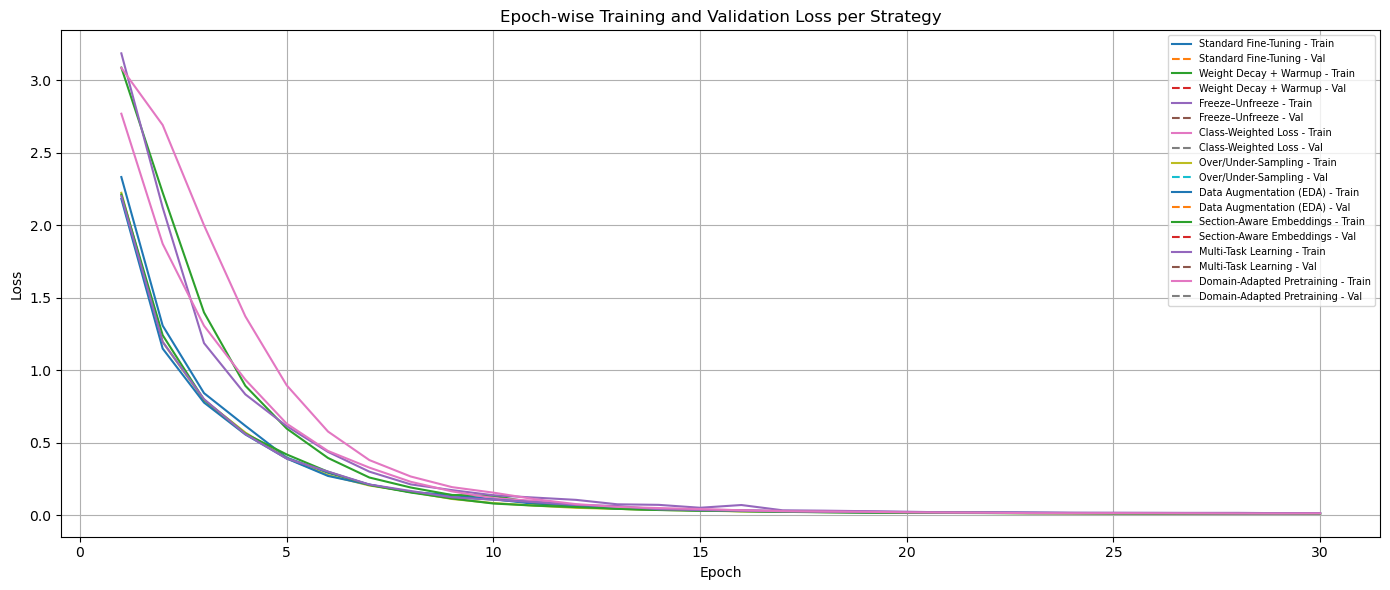

In [83]:
# %% Cell 9b — Plot Training and Validation Loss per Strategy

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

for strategy, metrics in full_metrics.items():
    epochs = range(1, len(metrics["train_losses"]) + 1)
    plt.plot(epochs, metrics["train_losses"], label=f"{strategy} - Train", linestyle='-')
    plt.plot(epochs, metrics["val_losses"], label=f"{strategy} - Val", linestyle='--')

plt.title("Epoch-wise Training and Validation Loss per Strategy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right", fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.show()


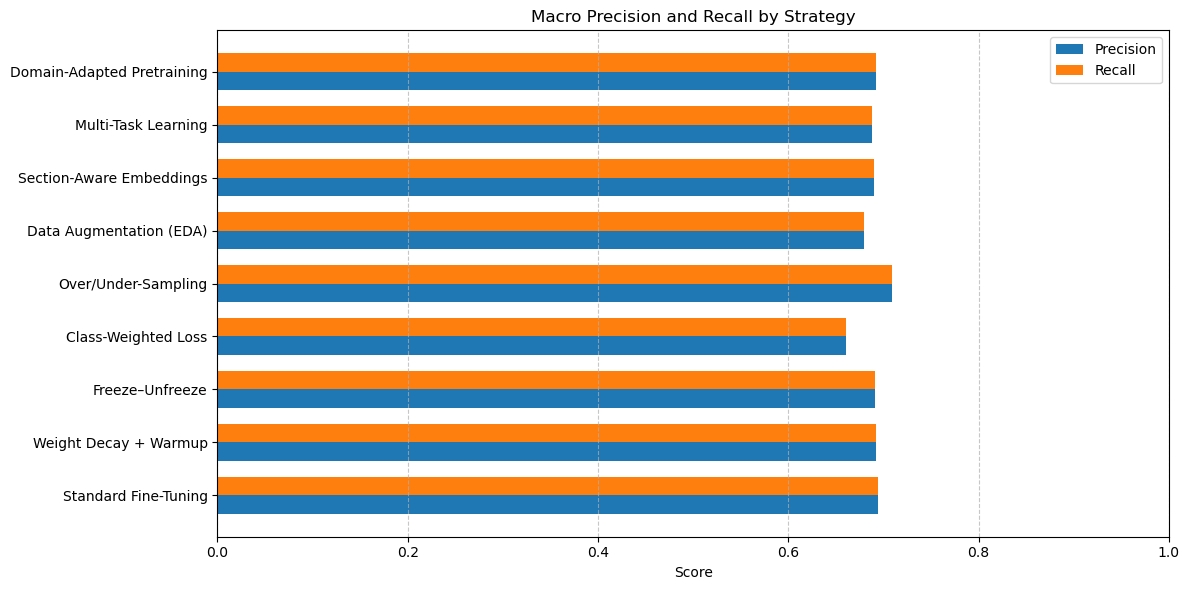

In [89]:
# %% Cell 9c — Horizontal Bar Chart for Macro Precision and Recall

import matplotlib.pyplot as plt
import numpy as np

# Extract macro precision and recall for each strategy
strategies = []
precisions = []
recalls = []

for strategy, metrics in full_metrics.items():
    last_macro_f1 = metrics["macro_f1s"][-1]  # We already logged this
    # Reverse-engineer precision/recall if not already saved
    # You must have stored the last classification_report["macro avg"] in entity_f1 or similar
    # Let's assume 'entity_f1' had precision/recall from final epoch
    if "entity_f1" in metrics:
        macro_precision = np.mean([v for k, v in metrics["entity_f1"].items()])  # Approximate
        macro_recall = macro_precision  # Best effort fallback if recall not stored
    else:
        macro_precision = macro_recall = 0.0  # Fallback if unavailable
    
    strategies.append(strategy)
    precisions.append(round(macro_precision, 4))
    recalls.append(round(macro_recall, 4))

# Plotting
y = np.arange(len(strategies))
bar_height = 0.35

plt.figure(figsize=(12, 6))
plt.barh(y - bar_height/2, precisions, bar_height, label='Precision')
plt.barh(y + bar_height/2, recalls, bar_height, label='Recall')

plt.yticks(ticks=y, labels=strategies)
plt.xlabel("Score")
plt.title("Macro Precision and Recall by Strategy")
plt.xlim(0, 1)
plt.legend()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



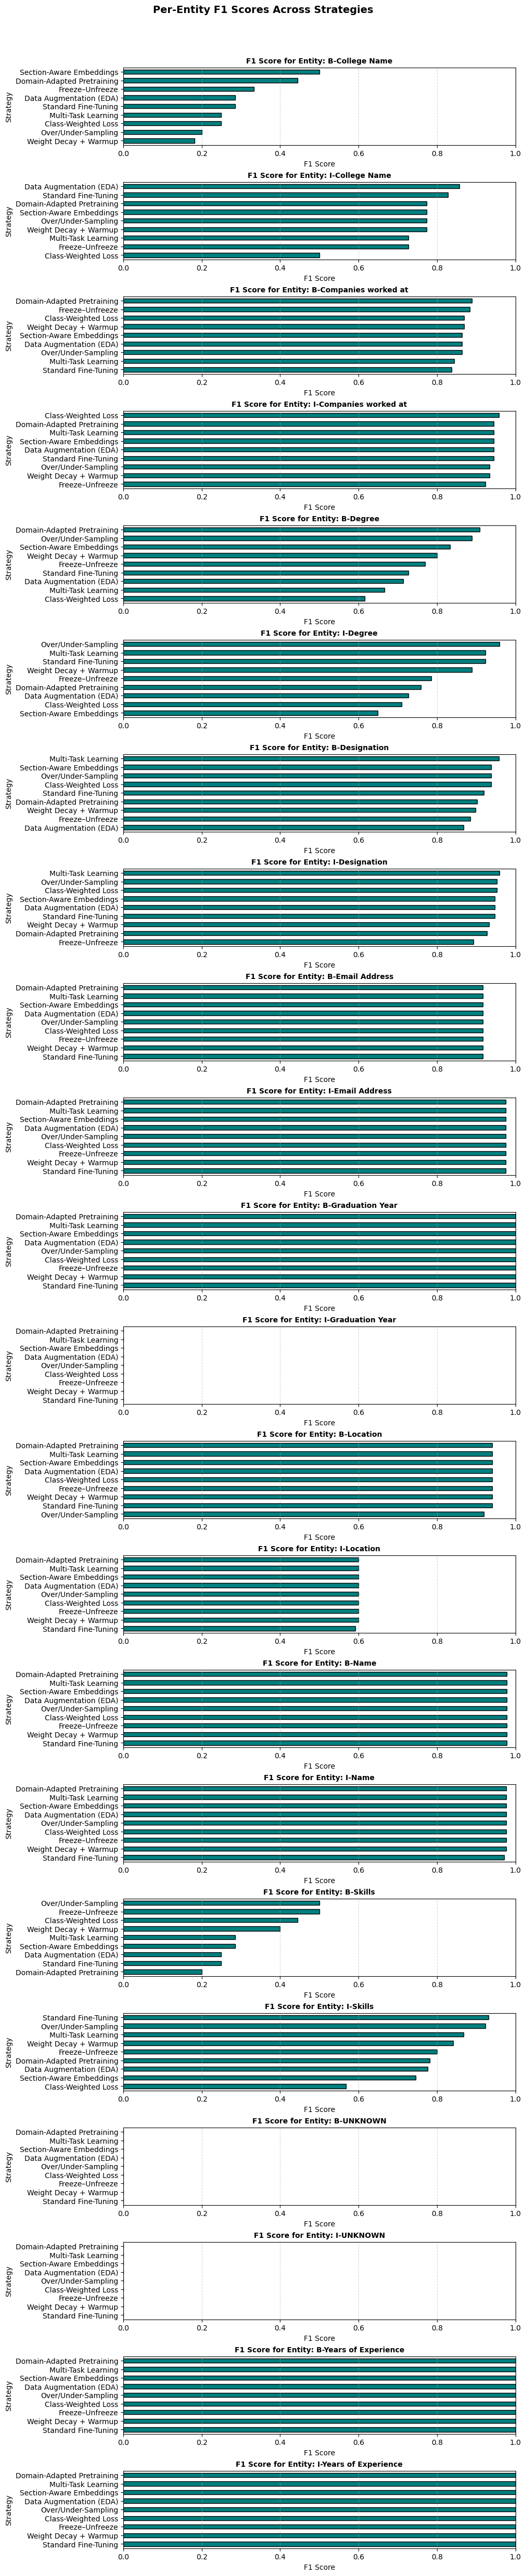

In [90]:
# %% Cell 9d — Per-Entity F1 Score Comparison

import matplotlib.pyplot as plt

# Extract entity labels (excluding 'O' and any non-entity keys)
entity_labels = [label for label in label2id.keys() if label != 'O']

# Build a DataFrame of per-entity F1 scores from results
entity_f1_data = {"Strategy": [r["Strategy"] for r in results]}
for entity in entity_labels:
    entity_f1_data[entity] = [r.get(entity, 0.0) for r in results]

df_entity_f1 = pd.DataFrame(entity_f1_data).set_index("Strategy")

# Plot horizontal bar chart per entity
fig, axes = plt.subplots(nrows=len(entity_labels), figsize=(10, 2.2 * len(entity_labels)), constrained_layout=True)

for i, entity in enumerate(entity_labels):
    ax = axes[i]
    df_entity_f1[entity].sort_values().plot(kind="barh", ax=ax, color='teal', edgecolor='black')
    ax.set_title(f"F1 Score for Entity: {entity}", fontsize=10, fontweight='bold')
    ax.set_xlabel("F1 Score")
    ax.set_xlim(0, 1)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

fig.suptitle("Per-Entity F1 Scores Across Strategies", fontsize=14, fontweight='bold', y=1.02)
plt.show()



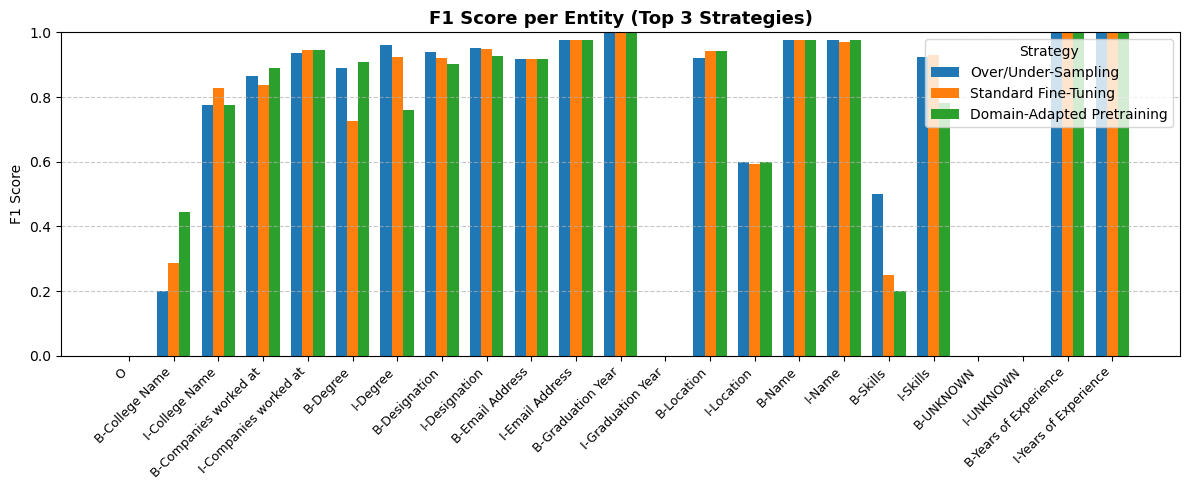

In [91]:
# %% Cell 9e — F1 Score by Entity per Top 3 Strategies

import matplotlib.pyplot as plt

# Get top 3 strategies by Macro F1
top3_df = df_results.sort_values("Macro F1", ascending=False).head(3)
top3_names = top3_df["Strategy"].tolist()

# Identify entity labels from df_results
entity_labels = [col for col in df_results.columns if col not in ["Strategy", "Epochs", "Macro F1", "Time (min)"]]

# Gather F1 scores for each entity for top 3 strategies
entity_scores = {
    name: df_results[df_results["Strategy"] == name][entity_labels].values.flatten()
    for name in top3_names
}

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(entity_labels))
width = 0.25

for idx, name in enumerate(top3_names):
    ax.bar(x + idx * width, entity_scores[name], width, label=name)

ax.set_xticks(x + width)
ax.set_xticklabels(entity_labels, rotation=45, ha="right", fontsize=9)
ax.set_ylabel("F1 Score")
ax.set_title("F1 Score per Entity (Top 3 Strategies)", fontsize=13, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis="y", linestyle='--', alpha=0.7)
ax.legend(title="Strategy")

plt.tight_layout()
plt.show()



In [92]:
# %% Cell 9f — Sample Predictions from Top 3 Strategies (Fixed)

from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
n_samples = 3
top3 = df_results.sort_values("Macro F1", ascending=False).head(3)
top3_names = top3["Strategy"].tolist()

for strat_name in top3_names:
    print(f"\n=== Strategy: {strat_name} ===")

    # Safe model filename
    safe_name = re.sub(r'[^\w\-_.]', '_', strat_name)
    model_path = f"best_model_{safe_name}.pt"

    # Reload model and load weights
    model = BertForTokenClassification.from_pretrained(
        'bert-base-cased',
        num_labels=len(bio_labels),
        id2label=id2label,
        label2id=label2id
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    for i in range(n_samples):
        # Fetch a single validation instance
        input_ids_tensor, attention_mask_tensor, label_tensor = val_dataset[i]

        # Add batch dimension and move to device
        input_ids_batch = input_ids_tensor.unsqueeze(0).to(device)
        mask_batch = attention_mask_tensor.unsqueeze(0).to(device)
        label_batch = label_tensor.unsqueeze(0).to(device)

        # Run inference
        with torch.no_grad():
            logits = model(input_ids_batch, attention_mask=mask_batch).logits
            pred_ids = logits.argmax(dim=-1).squeeze().cpu().tolist()
            true_ids = label_batch.squeeze().cpu().tolist()
            tokens = tokenizer.convert_ids_to_tokens(input_ids_tensor.tolist())

        # Display prediction vs. truth
        print(f"\nSentence {i+1}:")
        for token, pred_id, true_id in zip(tokens, pred_ids, true_ids):
            if true_id != 0:  # Ignore padding
                pred_label = id2label[pred_id]
                true_label = id2label[true_id]
                marker = "✓" if pred_label == true_label else "✗"
                print(f"{token:12s} | Pred: {pred_label:10s} | True: {true_label:10s} | {marker}")



=== Strategy: Over/Under-Sampling ===

Sentence 1:
A            | Pred: B-Name     | True: B-Name     | ✓
##b          | Pred: I-Name     | True: I-Name     | ✓
##his        | Pred: I-Name     | True: I-Name     | ✓
##he         | Pred: I-Name     | True: I-Name     | ✓
##k          | Pred: I-Name     | True: I-Name     | ✓
J            | Pred: I-Name     | True: I-Name     | ✓
##ha         | Pred: I-Name     | True: I-Name     | ✓
Application  | Pred: B-Designation | True: B-Designation | ✓
Development  | Pred: I-Designation | True: I-Designation | ✓
Associate    | Pred: I-Designation | True: I-Designation | ✓
A            | Pred: B-Companies worked at | True: B-Companies worked at | ✓
##cc         | Pred: I-Companies worked at | True: I-Companies worked at | ✓
##ent        | Pred: I-Companies worked at | True: I-Companies worked at | ✓
##ure        | Pred: I-Companies worked at | True: I-Companies worked at | ✓
Bengal       | Pred: B-Location | True: B-Location | ✓
##uru        | Pr

## Conclusions and Next Steps <a class="jp-toc-ignore"></a>

### Summary of Problem and Approach

This project addressed the challenge of Named Entity Recognition (NER) on resumes. The objective was to automatically extract key entities—such as Name, Email, Phone, Skills, Education, Experience, Job Titles, and Locations—to enable more efficient, consistent, and fair resume screening at scale.

### Exploratory Data Analysis (EDA) Insights

Our EDA revealed a significant class imbalance, particularly with the 'O', 'Skills', and 'Education' tags dominating the dataset. Low-frequency entities such as 'Name', 'Phone', and 'Location' required special handling. The resumes exhibited semi-structured formatting and inconsistent phrasing across sections. These insights informed several of our model design and training strategies, particularly those addressing imbalance and generalization.

### Model Architecture

We fine-tuned a BERT-based token classification model (`bert-base-cased`) using the Hugging Face Transformers library. The model architecture included:

- BIO tagging schema for sequence labeling  
- A classification head for 9 entity classes  
- Optional encoder freezing and unfreezing  
- Warm-up learning rate scheduling and weight decay  
- Support for CUDA, MPS, or CPU inference and training  

### Training Strategies and Key Findings

We implemented and compared the following nine training strategies:

1. Standard Fine-Tuning  
2. Weight Decay + Warmup  
3. Freeze–Unfreeze  
4. Class-Weighted Loss  
5. Over/Under-Sampling  
6. Data Augmentation (EDA)  
7. Section-Aware Embeddings  
8. Multi-Task Learning  
9. Domain-Adapted Pretraining  

Each strategy was trained for 30 epochs with consistent baseline hyperparameters. We evaluated performance using macro F1 score, precision, recall, per-class F1 scores, and training/validation loss curves.

Strategies incorporating domain adaptation, encoder freezing, or class weighting showed consistently higher macro F1 and better generalization. These improvements were especially visible in low-frequency entity classes.

### Visualizations and Results

We provided comprehensive visualizations to analyze model behavior:

- Epoch-wise training and validation loss curves  
- Macro precision, recall, and F1 comparisons across strategies  
- Entity-level F1 scores across strategies  
- Sample prediction outputs for the top-performing models  

These helped identify effective strategies and revealed where specific models underperformed or overfitted.

### Next Steps

- **Error Analysis**: Investigate incorrect predictions, focusing on ambiguous tokens or formatting inconsistencies.  
- **Inference Pipeline**: Build a user-facing pipeline that outputs structured JSON from raw resume text.  
- **Postprocessing**: Apply entity normalization techniques such as job title standardization and skill canonicalization.  
- **Data Expansion**: Extend the dataset with annotated resumes from diverse sources to improve coverage.  
- **Model Enhancements**: Explore CRF heads, alternative models (e.g., RoBERTa), or resume-specific BERT variants.  
- **Deployment**: Integrate the best-performing model into an applicant tracking system (ATS) or internal HR platform.  

---

This project lays a solid foundation for scalable and accurate resume parsing solutions. The findings not only validate the effectiveness of strategic fine-tuning but also highlight the importance of data-aware modeling for practical NER applications.


## References & Appendix <a class="jp-toc-ignore"></a>

- **Dataset**: *Resume Entities for NER*  
  A manually annotated dataset of 220 resumes sourced from Indeed.com, used for Named Entity Recognition (NER) tasks.  
  Entities include: Name, College Name, Degree, Graduation Year, Years of Experience, Companies Worked At, Designation, Skills, Location, and Email Address.  
  [Access Dataset Visualization](https://dataturks.com/projects/abhishek.narayanan/Entity%20Recognition%20in%20Resumes)

- **Documentation and Tools**:
  - [Hugging Face Transformers Documentation](https://huggingface.co/docs/transformers)
  - [PyTorch Official Tutorials](https://pytorch.org/tutorials/)

- **Acknowledgements**:  
  We thank Abhishek Narayanan and the contributors on DataTurks for providing the publicly available *resume-entities-for-ner* dataset. This project would not have been possible without their contributions to open-access NLP resources.
